In [17]:
import tensorflow
import keras
import catboost
import itertools
import time
import re
import gc
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance

In [18]:
sales_full = pd.read_pickle('sales_full_enh.pkl')

In [19]:
sales_full.fillna(0, inplace=True)

categorical_columns = ['month', 'year', 'item_id', 'shop_id', 'category_type', 'item_category_id', 'city','item_category_id']

In [20]:
# discard first 12 months because we use features generated by past 12 months so no valid information there
train_set = sales_full.query('date_block_num >= 12 and date_block_num < 32').copy()
# validation on 2nd to the last seen month
validation_set = sales_full.query('date_block_num >= 32 and date_block_num < 33').copy()
# predict on last month - what's the item_cnt_month in next month will be
test_set = sales_full.query('date_block_num == 33').copy()

In [21]:
## Doesn't improve the accuracy
# def get_grpby(data, grpby, column, fun, column_rename):
#     g = data.groupby(grpby).agg({column: fun})
#     g.columns = [column_rename]
#     return g.reset_index()

# shop_mean = get_grpby(train_set, ['shop_id'], 'predict_item_cnt_month', 'mean', 'shop_mean')
# item_mean = get_grpby(train_set, ['item_id'], 'predict_item_cnt_month', 'mean', 'item_mean')
# month_mean = get_grpby(train_set, ['month'], 'predict_item_cnt_month', 'mean', 'month_mean')

# train_set = pd.merge(train_set, shop_mean, on=['shop_id'], how='left')
# train_set = pd.merge(train_set, item_mean, on=['item_id'], how='left')
# train_set = pd.merge(train_set, month_mean, on=['month'], how='left')

# validation_set = pd.merge(validation_set, shop_mean, on=['shop_id'], how='left')
# validation_set = pd.merge(validation_set, item_mean, on=['item_id'], how='left')
# validation_set = pd.merge(validation_set, month_mean, on=['month'], how='left')

# test_set = pd.merge(test_set, shop_mean, on=['shop_id'], how='left')
# test_set = pd.merge(test_set, item_mean, on=['item_id'], how='left')
# test_set = pd.merge(test_set, month_mean, on=['month'], how='left')

In [22]:
# Split into X and Y
X_train = train_set.drop(['predict_item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['predict_item_cnt_month'].astype(int)
X_validation = validation_set.drop(['predict_item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['predict_item_cnt_month'].astype(int)

In [23]:
test = pd.read_csv("data/test.csv", dtype={'ID': 'int32', 'shop_id': 'int8', 'item_id': 'int16'})
X_test = pd.merge(test, test_set, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.drop('predict_item_cnt_month', axis=1, inplace=True)
X_test = X_test[X_train.columns]

In [24]:
cat_features = [ i for i, e in enumerate(X_train.columns) if e in categorical_columns]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=5,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=8
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

0:	learn: 1.1111135	test: 1.1072740	best: 1.1072740 (0)	total: 7.56s	remaining: 1h 2m 51s
50:	learn: 0.7970097	test: 0.9043463	best: 0.9043463 (50)	total: 5m 32s	remaining: 48m 45s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8978762407
bestIteration = 70

Shrink model to first 71 iterations.


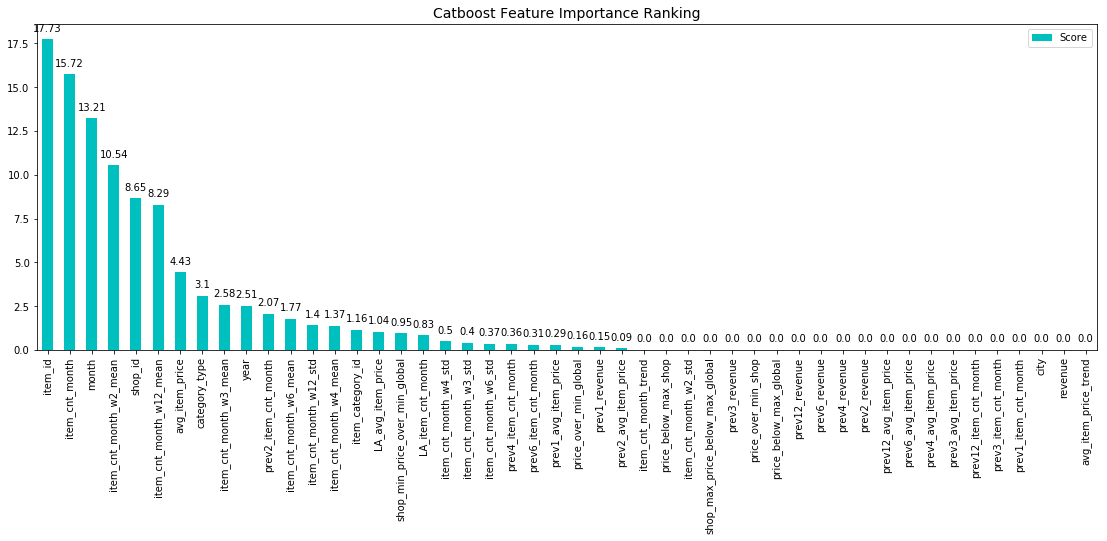

In [25]:
all_feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
all_feature_score = all_feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = all_feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = all_feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [26]:
xgb_features = all_feature_score.loc[all_feature_score.Score > 1, 'Feature'].values
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000, 
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         learning_rate=0.05)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[01:00:29] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.11098	validation_1-rmse:1.09474
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.853676	validation_1-rmse:0.907207
[40]	validation_0-rmse:0.803016	validation_1-rmse:0.884524
[60]	validation_0-rmse:0.788774	validation_1-rmse:0.880555
[80]	validation_0-rmse:0.780446	validation_1-rmse:0.879263
Stopping. Best iteration:
[77]	validation_0-rmse:0.781755	validation_1-rmse:0.878976



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

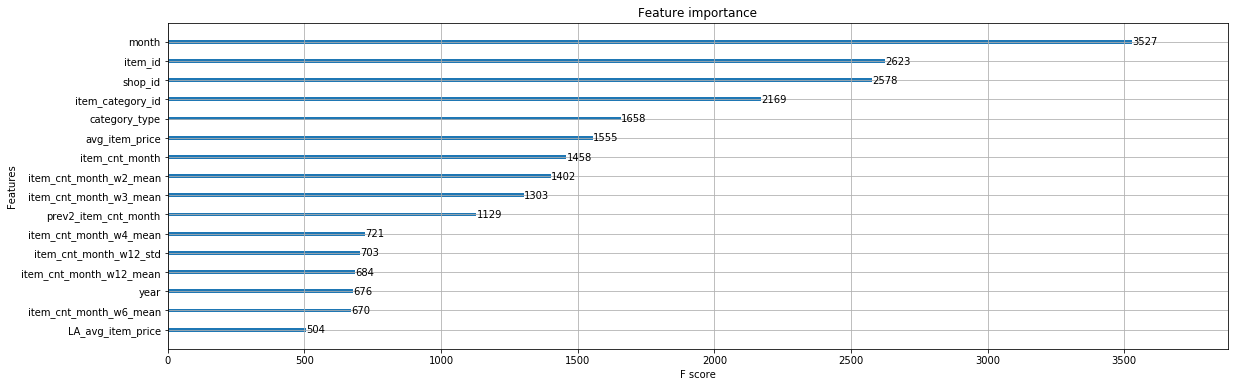

In [27]:
plot_importance(xgb_model)

In [28]:
def create_submision(result):
    test_i = test.copy()
    test_i['item_cnt_month'] = result
    test_i = test_i.drop(['shop_id', 'item_id'], axis=1)
    test_i['item_cnt_month'] = test_i['item_cnt_month'].clip(0,20)
    return test_i

xgb_test_pred = xgb_model.predict(xgb_test)
create_submision(xgb_test_pred).to_csv('results/v2_xgb_predict_on_future_1m_lr005_2.csv', index=False)